# Design an Image Classifier using Deep Learning
These articles describes briefly the state of the art in Image Classification.
The main reference it is the ImageNet competion.
1. https://towardsdatascience.com/deep-learning-for-image-classification-why-its-challenging-where-we-ve-been-and-what-s-next-93b56948fcef
2. https://medium.com/comet-app/review-of-deep-learning-algorithms-for-image-classification-5fdbca4a05e2 
3. https://adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html <br>

To summarize the main architectures used for image classification are the following:

<img src="graph_classification.png" alt="Drawing" style="width: 600px;"/>
   

# 0) Import dependencies

In [1]:
# Import required libraries
import os                                             
import matplotlib.pyplot as plt                       
import numpy as np
import cv2
from PIL import Image # faster than opencv in opening images
import glob

from sklearn.metrics import confusion_matrix
import itertools  

from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, concatenate
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import TensorBoard 


Using TensorFlow backend.


# 1) Get Data

We are dealing with a Multi-Class Image Classification problem. 
> 1. Read the images and define the labels (one hot encoding) associated to them
2. Check if class imbalance it is an issue
3. Select how to preprocess the data
4. Build a generator that automatically preprocess and augment the data


### 1.1) Read the images and define the labels (one hot encoding) associated to them <br>

Name: maniche_corte= [ 0.  1.  0.  0.  0.]
Name: monospalla= [ 0.  0.  0.  1.  0.]
Name: maniche_a_34= [ 1.  0.  0.  0.  0.]
Name: senza_maniche= [ 0.  0.  0.  0.  1.]
Name: senza_maniche= [ 0.  0.  0.  0.  1.]


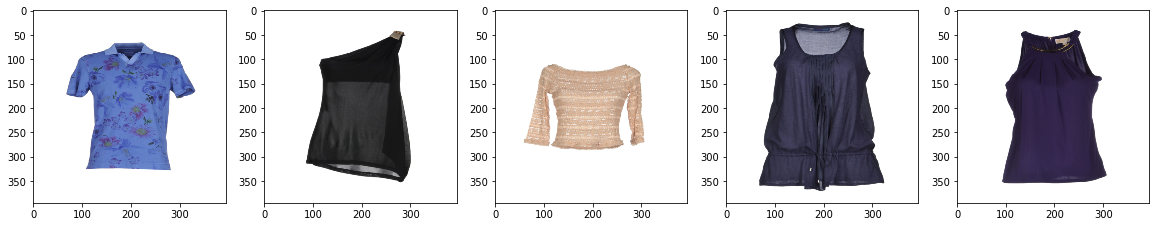

('Input Shape', (3880, 395, 395, 3))
('Label Shape', (3880, 5))


In [2]:
root = "dati_maniche/"
img_type = ".png"
class_names  = ["maniche_a_34" , "maniche_corte", "maniche_lunghe", "monospalla", "senza_maniche"]
images = []
labels = []
num_images_per_class = []

for i in range(0,len(class_names)):
    temp_path = root + class_names[i] + "/*" + img_type
    count = 0
    for filename in glob.glob(temp_path): 
        # Counter
        count = count + 1
        
        # Get Image
        temp_image = np.array(Image.open(filename))
        images.append(temp_image)
        
        # Get Label (one hot encoding)
        temp_label = np.zeros(len(class_names))
        temp_label[i] = 1
        labels.append(temp_label)
        
    num_images_per_class.append(count)

num_images_per_class = np.asarray(num_images_per_class)
    
# Check 5 images
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
for k in range(0,num_images):
    num = int(np.random.randint(len(images),size=1))
    axes[k].imshow(images[num]) 
    index = int(np.where(labels[num] == 1)[0])
    print("Name: " + str(class_names[index]) + "= " + str(labels[num]))
plt.show()

# The data has to be numpy array not list
X = np.asarray(images)
Y = np.asarray(labels)

# Size Check
print("Input Shape", X.shape)
print("Label Shape", Y.shape)

# Save data locally
np.save('data_X.npy', X)
np.save('data_Y.npy', Y)
# To load data
#X_load = np.load('data_X.npy')
#Y_load = np.load('data_Y.npy')

        
# Conclusion we have number of images = 3880, image_size = 395x395 , channels=3 color images

### 2.2) Check if class imbalance it is an issue

In [3]:
for i in range(0, len(class_names)):
    print("Numbers of " + str(class_names[i]) + " = " + str(num_images_per_class[i]) )


Numbers of maniche_a_34 = 853
Numbers of maniche_corte = 978
Numbers of maniche_lunghe = 864
Numbers of monospalla = 374
Numbers of senza_maniche = 811


There is a strong difference in number between "monospalla" and all the other classes. However "monospalla" it is quite a specif case that it is really difficult to confuse with the others. Anyway, to avoid any issue related to class imbalance we will consider for all the class 250 images. We will use this dataset to train the algorithm and the discarded images will be used to validate. The classification task it is related to the shape of the dress, for this reason we think that 250 image for each class will be sufficient.

In [4]:
# X = ('Input Shape', (3880, 395, 395, 3))
# Y = ('Label Shape', (3880, 5))

X_train = []
Y_train = []
X_val = []
Y_val = []

chosen_num_images = 250 # it has to be less than 374
start = 0
stop = num_images_per_class[0]
for i in range(0, (len(class_names))):
    #print("start: =",start)
    #print("stop: =",stop)
    
    temp_X_train = X[start:(start+chosen_num_images-1),:,:,:]
    temp_Y_train = Y[start:(start+chosen_num_images-1),:]
    
    temp_X_val = X[(start+chosen_num_images):stop,:,:,:]
    temp_Y_val = Y[(start+chosen_num_images):stop,:]
    
    X_train.append(temp_X_train)
    Y_train.append(temp_Y_train)
    X_val.append(temp_X_val)
    Y_val.append(temp_Y_val)

    if (i!=(len(class_names)-1)):
        start = start + num_images_per_class[i]
        stop = stop + num_images_per_class[i+1]

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_val = np.asarray(X_val)
Y_val = np.asarray(Y_val)

print("--------- OLD ----------------")
print("X_train Shape = ", X_train.shape)
print("Y_train Shape = ", Y_train.shape)
print("X_val Shape = ", X_val.shape)
print("Y_val Shape = ", Y_val.shape)

X_train = np.concatenate((X_train[0],X_train[1],X_train[2],X_train[3],X_train[4]),0)
Y_train = np.concatenate((Y_train[0],Y_train[1],Y_train[2],Y_train[3],Y_train[4]),0)
X_val = np.concatenate((X_val[0],X_val[1],X_val[2],X_val[3],X_val[4]),0)
Y_val = np.concatenate((Y_val[0],Y_val[1],Y_val[2],Y_val[3],Y_val[4]),0)

print("--------- NEW ----------------")
print("X_train Shape = ", X_train.shape)
print("Y_train Shape = ", Y_train.shape)
print("X_val Shape = ", X_val.shape)
print("Y_val Shape = ", Y_val.shape)
        

--------- OLD ----------------
('X_train Shape = ', (5, 249, 395, 395, 3))
('Y_train Shape = ', (5, 249, 5))
('X_val Shape = ', (5,))
('Y_val Shape = ', (5,))
--------- NEW ----------------
('X_train Shape = ', (1245, 395, 395, 3))
('Y_train Shape = ', (1245, 5))
('X_val Shape = ', (2630, 395, 395, 3))
('Y_val Shape = ', (2630, 5))


### 1.3) Preprocessing choice

The goal it is to develop an image classifier able to distinguish between different shape of T-Shirt. The difference among them it is mainly related to the shape that they have. For this reason it is not useful to consider the color image, because we are just introducing some information that are not helpful. To make an example, if our goal it is distinguish between shoes of different colors, we will need to take into account the color image. But if our goal it is related to the shape of the shoes,  grayscale it is sufficient. Furthermore we simplify a lot the required model.
Thus the preprocessing choice related to our problem are the following:
> * grayscale images will be used
* the images will be resize to 128x128 to allow a larger batch size ( we want to speed up convergence)
* the images will be rescaled (or normalize) to be in range 0,1

('X_train_pp Shape = ', (1245, 128, 128))
('X_val_pp Shape = ', (2630, 128, 128))
Name: maniche_a_34= [ 1.  0.  0.  0.  0.]


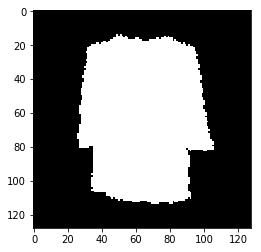

In [5]:
# Preprocessing Normalize and Resize (128,128)
# Do this step for both X_train and X_val
X_train_pp = []
X_val_pp = []

shape_desired = (128,128)
for i in range(0, X_train.shape[0]):
    temp_gray = cv2.cvtColor(X_train[i,:,:,:], cv2.COLOR_BGR2GRAY)
    temp_gray_resize = cv2.resize(temp_gray, shape_desired, interpolation=cv2.INTER_LANCZOS4)
    temp_gray_mask = (1 - temp_gray_resize/255) # background 0 , dress 1
    X_train_pp.append(temp_gray_mask)
   
for i in range(0, X_val.shape[0]):
    temp_gray = cv2.cvtColor(X_val[i,:,:,:], cv2.COLOR_BGR2GRAY)
    temp_gray_resize = cv2.resize(temp_gray, shape_desired, interpolation=cv2.INTER_LANCZOS4)
    temp_gray_mask = (1 - temp_gray_resize/255) # background 0 , dress 1
    X_val_pp.append(temp_gray_mask)
    
X_train_pp = np.asarray(X_train_pp) 
X_val_pp = np.asarray(X_val_pp) 

print("X_train_pp Shape = ", X_train_pp.shape)
print("X_val_pp Shape = ", X_val_pp.shape)

plt.imshow(X_train_pp[3,:,:], cmap="gray")
index = int(np.where(Y_train[3,:] == 1)[0])
print("Name: " + str(class_names[index]) + "= " + str(Y_train[3,:]))



### 1.4) Build Image Data Generator

We have decreased a lot the number of data, therefore it is better to use an Image Data generator, performing also augmentation. We will augment the data using only horizonal flip, small rotation and zoom.

Name: maniche_lunghe= [ 0.  0.  1.  0.  0.]
Name: monospalla= [ 0.  0.  0.  1.  0.]
Name: monospalla= [ 0.  0.  0.  1.  0.]
Name: maniche_a_34= [ 1.  0.  0.  0.  0.]
Name: maniche_corte= [ 0.  1.  0.  0.  0.]


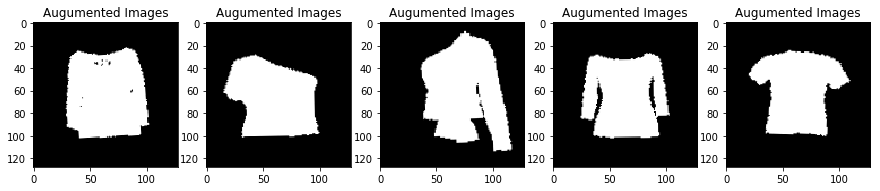

In [6]:
X_train_pp = X_train_pp[:,:,:,np.newaxis]
X_val_pp = X_val_pp[:,:,:,np.newaxis]

SEED=10
def my_generator(X_train_pp, Y_train, batch_size):
    data_generator = ImageDataGenerator(
            horizontal_flip=True,
            width_shift_range=0.01,
            height_shift_range=0.01,
            rotation_range=5,
            zoom_range=0.1).flow(X_train_pp, Y_train, batch_size, seed=SEED)
    while True:
        x_batch, y_batch = data_generator.next()
        yield x_batch, y_batch

# Test Augmented Data Generator
image_batch, label_batch = next(my_generator(X_train_pp, Y_train, batch_size=8))

num_data = 5
for i in range(0, num_data):
    index = int(np.where(label_batch[i,:] == 1)[0])
    print("Name: " + str(class_names[index]) + "= " + str(label_batch[i,:]))

fix, ax = plt.subplots(1,num_data, figsize=(15,7))
for i in range(0,num_data):
    ax[i].imshow(image_batch[i,:,:,0],cmap='gray')
    ax[i].set_title('Augumented Images')
 
plt.show()


# 2) Define the Model

Let's try a simple and fast model. We know that Unet perform really well for image segentation. In this case we have binary images that are usually used as input of Unet models. However, our goal it is classification. Anyway let's take advange of skip connections (they make the learning really fast) and just add a fully connected layer at the end of our model. This layer will be our classifier layer in charge of converting a set of filter into five class probability values.

In [7]:
def get_model():
    # Unet https://github.com/rachitk/UNet-Keras-TF/blob/master/unet_build.py
    input_img = Input(shape=(128,128,1)) 
    
    conv1 = Conv2D(4, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    up4 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=3)
    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(up4)

    up5 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4), conv1], axis=3)
    conv5 = Conv2D(4, (3, 3), activation='relu', padding='same')(up5)

    #output_layer = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv5)

    # Fully connected layer
    x = Flatten()(conv5)
    x = Dropout(0.5)(x)
    x = Dense(100, activation='relu')(x)
    output_layer = Dense(len(class_names), activation='softmax')(x)
    
    unet = Model(inputs=[input_img], outputs=[output_layer])
    return unet

model_check =get_model()
print(model_check.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 4)  40          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 4)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 8)    296         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

# 3) Train the Model

### 3.1) Define Metric 

The metric used to measure the performance of our model it is the F1 Score. <br>
More information available at: https://en.wikipedia.org/wiki/F1_score <br>
> **What is the goal of our classifier?** <br>
To aswer to this question we need to consider both recall and precision. <br>
* Precision is defined as: <br>
$$ \begin{equation} P =\frac{TP}{TP+FP}\end{equation}$$ <br>
It tells us the proportion (in percentage value) of positive identifications (Looking at the total validation set, what is the percetage describing how many times our model was classying the image correctly?). For example, if the precision it is 0.6, this means that the classifier has classified 60% of the validation images correctly. 
* Recall is defined as: <br>
$$ \begin{equation} R =  \frac{TP}{TP+FN}\end{equation}$$ <br>
it tells us, how many False Negative (the algorihtm has predicted 0 but the ground truth it is 1) the classifier correctly identifies.

Note that these definition of precision are recall are given for a specific chosen class. If we want the precision and recall of the all classifier we need to average the predicition and recall founded for each classes. A detailed explaination on how to do this it is available in part **4 Test Model** . Indeed after testing the model, we will compute, firstly, the Confusion Matrix then the precision, recall and f1 score for each class and finally, we will average the obtained result to have a number able to tell us information about the classifier.

The next block provides the function required to calculate precision, recall, f1 score. Note that these value are related to all the classes. So this means that the precsion, recall and f1 are like average values telling use how good the algorithm perform for all the classes.  

Explaination of confusion matrix and metric it available here: https://en.wikipedia.org/wiki/Confusion_matrix <br>
Confusion Matrix implentation scikit-learn: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py <br>

In [8]:
def round_f(vec):
    # This function given a input vector return a vector like [0 .... 1 ....0] in which all the 
    # elements are zeros expect one element that is 1.
    out = []
    for i in range(vec.shape[0]):
        max_index = np.argmax(vec[i,:])
        rounded_vector = np.zeros((vec[0].shape))
        rounded_vector[max_index] = 1
        out.append(rounded_vector)
    out = np.asarray(out)    
    return out

def CM(y_true,y_pred):
    # Batch wise confusion matrix for multiclass classification
    # This function calculate the confusion matrix of the overall classifier. It outputs the average True Positive, True Negative,
    # False Positive and False negative.
    TP = np.sum(np.round(np.clip(y_true * y_pred, 0, 1))) # true positives looking at all the classes
    TP_plus_FP = np.sum(np.round(np.clip(y_pred, 0, 1))) # predited positives  looking at all the classes
    FP = TP_plus_FP - TP
    TP_plus_FN = np.sum(np.round(np.clip(y_true, 0, 1))) # possible positives  looking at all the classes
    FN = TP_plus_FN-TP
    TN = y_true.shape[0] - TP # true negative (len y_true or y_pred - TP)
    return TP,FP,FN,TN

def recall(y_true, y_pred):
    # Recall metric only computes a batch-wise average of recall.
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # true positives
    FN = K.sum(K.round(K.clip(y_true, 0, 1))) # possible positives
    recall = TP / (FN + K.epsilon())
    return recall

def precision(y_true, y_pred):
    # Precision metric only computes a batch-wise average of precision.
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # true positives
    FP = K.sum(K.round(K.clip(y_pred, 0, 1))) # predited positives
    precision = TP / (FP + K.epsilon())
    return precision

def f1(y_true,y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))


### 3.2 Train the Model

In [9]:
# Type in a terminal (tensorboard --logdir=/tmp/classification) to see tensoboard
my_model =  get_model()
my_model.compile(optimizer=Adam(lr=2e-4),loss='categorical_crossentropy' , metrics=[f1,precision,recall]) #optimizer=Adam(lr=2e-4)

# Early stopping
weight_saver = ModelCheckpoint('model-hpa.h5',  monitor='val_f1',  verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)

batch_size = 10
hist = my_model.fit_generator(my_generator(X_train_pp, Y_train, batch_size),
                               steps_per_epoch = int(X_train_pp.shape[0]/batch_size),
                               validation_data = (X_val_pp, Y_val),
                               epochs=30, verbose=1,
                               callbacks = [weight_saver, TensorBoard(log_dir='/tmp/classification')])



Epoch 1/30
  4/124 [..............................] - ETA: 47:19 - loss: 1.6071 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00  

/home/manuel/.local/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.991700). Check your callbacks.
  % delta_t_median)


124/124 [==============================] - 105s 849ms/step - loss: 0.9497 - f1: 0.5047 - precision: 0.6099 - recall: 0.4589 - val_loss: 0.4830 - val_f1: 0.8350 - val_precision: 0.8532 - val_recall: 0.8194

Epoch 00001: val_f1 improved from -inf to 0.83500, saving model to model-hpa.h5
Epoch 2/30
  5/124 [>.............................] - ETA: 4:31 - loss: 0.6497 - f1: 0.7436 - precision: 0.7711 - recall: 0.7200 - ETA: 5:40 - loss: 0.5872 - f1: 0.7716 - precision: 0.7972 - recall: 0.750

/home/manuel/.local/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149872). Check your callbacks.
  % delta_t_median)


124/124 [==============================] - 21s 173ms/step - loss: 0.5632 - f1: 0.7789 - precision: 0.8106 - recall: 0.7524 - val_loss: 0.4660 - val_f1: 0.8471 - val_precision: 0.8639 - val_recall: 0.8327

Epoch 00002: val_f1 improved from 0.83500 to 0.84711, saving model to model-hpa.h5
Epoch 3/30
124/124 [==============================] - 12s 94ms/step - loss: 0.4536 - f1: 0.8371 - precision: 0.8577 - recall: 0.8194 - val_loss: 0.4480 - val_f1: 0.8506 - val_precision: 0.8712 - val_recall: 0.8327

Epoch 00003: val_f1 improved from 0.84711 to 0.85060, saving model to model-hpa.h5
Epoch 4/30
124/124 [==============================] - 10s 83ms/step - loss: 0.4274 - f1: 0.8442 - precision: 0.8638 - recall: 0.8274 - val_loss: 0.3729 - val_f1: 0.8840 - val_precision: 0.9027 - val_recall: 0.8681

Epoch 00004: val_f1 improved from 0.85060 to 0.88396, saving model to model-hpa.h5
Epoch 5/30
124/124 [==============================] - 10s 82ms/step - loss: 0.3811 - f1: 0.8603 - precision: 0.8803 

### 3.3)  Plot training results

------------------------------------------------------
Training categorical_crossentropy loss: 0.120452296987
Training precision: 0.962483126866
Training recall: 0.956275298769
Training f1: 0.959215831419
------------------------------------------------------
------------------------------------------------------
Validation categorical_crossentropy loss: 0.400604352443
Validation precision: 0.910181657896
Validation recall: 0.906083642983
Validation f1: 0.908024780197
------------------------------------------------------


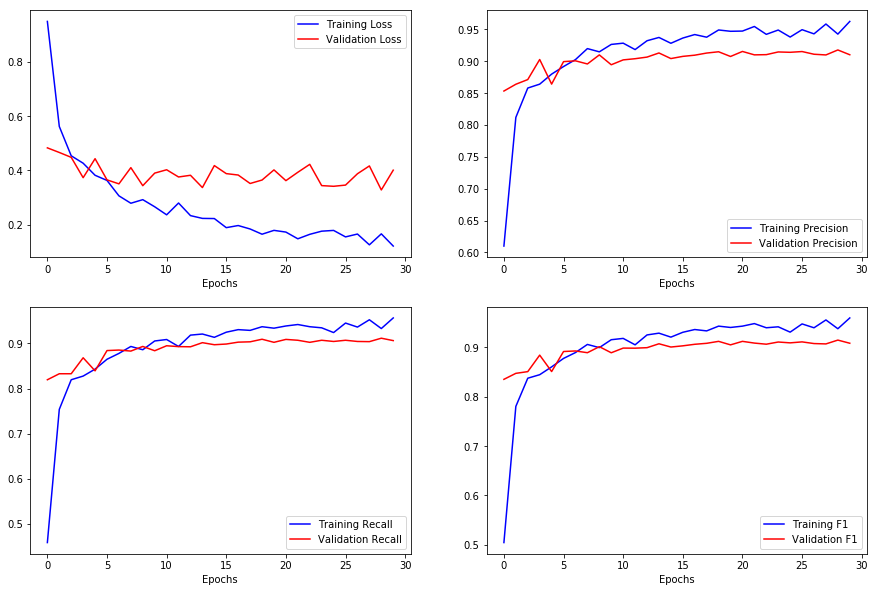

In [10]:
fig, ax = plt.subplots(2,2, figsize = (15,10))
ax[0,0].plot(hist.history['loss'], color='b',label='Training Loss')           # Training Loss
ax[0,0].plot(hist.history['val_loss'], color='r',label='Validation Loss')     # Validation Loss
ax[0,0].legend()
ax[0,0].set_xlabel('Epochs')
ax[0,1].plot(hist.history['precision'], color='b',label='Training Precision')     
ax[0,1].plot(hist.history['val_precision'], color='r', label='Validation Precision') 
ax[0,1].legend()
ax[0,1].set_xlabel('Epochs')
ax[1,0].plot(hist.history['recall'], color='b',label='Training Recall')      
ax[1,0].plot(hist.history['val_recall'], color='r', label='Validation Recall') 
ax[1,0].legend()
ax[1,0].set_xlabel('Epochs')
ax[1,1].plot(hist.history['f1'], color='b',label='Training F1')
ax[1,1].plot(hist.history['val_f1'], color='r', label='Validation F1') 
ax[1,1].legend()
ax[1,1].set_xlabel('Epochs')

plt.savefig( 'PLOT_NAME.png' ) # Save into result folder

print("------------------------------------------------------")
print ("Training categorical_crossentropy loss: " + str(hist.history['loss'][-1]))
print ("Training precision: " + str(hist.history['precision'][-1]))
print ("Training recall: " + str(hist.history['recall'][-1]))
print ("Training f1: " + str(hist.history['f1'][-1]))
print("------------------------------------------------------")

print("------------------------------------------------------")
print ("Validation categorical_crossentropy loss: " + str(hist.history['val_loss'][-1]))
print ("Validation precision: " + str(hist.history['val_precision'][-1]))
print ("Validation recall: " + str(hist.history['val_recall'][-1]))
print ("Validation f1: " + str(hist.history['val_f1'][-1]))
print("------------------------------------------------------")



# 4) Test the Model

In [11]:
WEIGHT_NAME= 'model-hpa.h5'
model1=get_model()
model1.load_weights(WEIGHT_NAME)

Y_hat = model1.predict(X_val_pp)
print("Example predicted output:", Y_hat[0,:])

# Let's round the output by setting the max of the vector =1, so if y=[0.1,0.2,0,0,0] it becames y=[0,1,0,0,0]
Y_hat = round_f(Y_hat)
#Y_hat = np.round(np.clip(Y_hat,0,1))  # Soft round, if y=[0.1,0.2,0,0,0] it becomes y=[0,0,0,0,0]
print("Example predicted output rounded:", Y_hat[0,:])


('Example predicted output:', array([  9.94766712e-01,   5.76458813e-04,   4.65318048e-03,
         3.47430205e-06,   2.95190631e-07], dtype=float32))
('Example predicted output rounded:', array([ 1.,  0.,  0.,  0.,  0.]))


### 5) Analyze the Results

It is time to anylize how well the classifier performs. As previously state to do this we need to calculate the confusion matrix. We will start calculating the Confusion Matrix for a multi-class classification problem.

Confusion matrix, without normalization
[[556  20  23   0   4]
 [ 34 673   2   4  15]
 [ 51   2 559   0   2]
 [  4   2   2 104  12]
 [ 11  12   2  27 509]]
Normalized confusion matrix
[[ 0.92  0.03  0.04  0.    0.01]
 [ 0.05  0.92  0.    0.01  0.02]
 [ 0.08  0.    0.91  0.    0.  ]
 [ 0.03  0.02  0.02  0.84  0.1 ]
 [ 0.02  0.02  0.    0.05  0.91]]


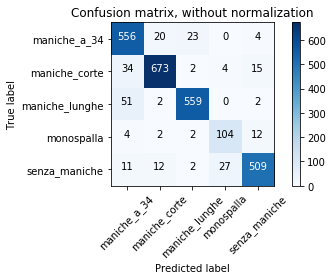

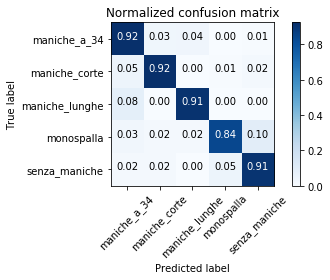

In [12]:
# Code from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix (This function takes a vector of labels not One how encoding)
cnf_matrix = confusion_matrix(Y_val.argmax(axis=1), Y_hat.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show() 

Now we have the confusion matrix. However to be able to calculate precision, recall and f1 score for each class we need to find true positive, true negative, false positive, false negative. <br>
>Question: Given a Multi-Class Classification problem and the associated confusion matrix, how do we calculate True Positive, True Negative, False Positive, False Negative?

The following image tells us how to do it!
<img src="multi_class_confusion_matrix.png" alt="Drawing" style="width: 600px;"/>

In [13]:
diag = np.diag(cnf_matrix)
TP_vec = []
FN_vec = []
FP_vec = []
TN_vec = []
for i in range(0,len(class_names)):
    TP = diag[i]
    FN = np.sum(cnf_matrix[i,:]) - TP
    FP = np.sum(cnf_matrix[:,i]) - TP
    TN = cnf_matrix.sum() - (FP + FN + TP)
    
    TP_vec.append(TP)
    FN_vec.append(FN)
    FP_vec.append(FP)
    TN_vec.append(TN)
    
TP_vec = np.asarray(TP_vec, dtype=float)
FN_vec = np.asarray(FN_vec, dtype=float)
FP_vec = np.asarray(FP_vec, dtype=float)
TN_vec = np.asarray(TN_vec, dtype=float)

# Check 
for i in range(0,len(class_names)):
    print("------------------------------------------------------")
    print( str(class_names[i]) + " True Positive: " +  str(TP_vec[i]))
    print( str(class_names[i]) + " False Negative: " +  str(FN_vec[i]))
    print( str(class_names[i]) + " False Positive: " +  str(FP_vec[i]))
    print( str(class_names[i]) + " True Negative: " +  str(TN_vec[i]))
    print("------------------------------------------------------")

    
    

------------------------------------------------------
maniche_a_34 True Positive: 556.0
maniche_a_34 False Negative: 47.0
maniche_a_34 False Positive: 100.0
maniche_a_34 True Negative: 1927.0
------------------------------------------------------
------------------------------------------------------
maniche_corte True Positive: 673.0
maniche_corte False Negative: 55.0
maniche_corte False Positive: 36.0
maniche_corte True Negative: 1866.0
------------------------------------------------------
------------------------------------------------------
maniche_lunghe True Positive: 559.0
maniche_lunghe False Negative: 55.0
maniche_lunghe False Positive: 29.0
maniche_lunghe True Negative: 1987.0
------------------------------------------------------
------------------------------------------------------
monospalla True Positive: 104.0
monospalla False Negative: 20.0
monospalla False Positive: 31.0
monospalla True Negative: 2475.0
------------------------------------------------------
-------

Let's now calculate **precision, recall, accuracy and f1 score** for each class

In [14]:
# reference https://en.wikipedia.org/wiki/Confusion_matrix
Precision_vec = []
Recall_vec = []
Accuracy_vec = []
F1Score_vec = []

for i in range(0, len(class_names)):
    
    Precision = TP_vec[i] / ( TP_vec[i] + FN_vec[i] )
    Recall =    TP_vec[i] / ( TP_vec[i] + FP_vec[i])
    Accuracy = ( TP_vec[i] + TN_vec[i] ) / ( TP_vec[i] + TN_vec[i] + FP_vec[i] + FN_vec[i] )
    F1Score =  ( 2*TP_vec[i] ) / (2*TP_vec[i] + FP_vec[i] + FN_vec[i])
    
    print("------------------------------------------------------")
    print(str(class_names[i]) + " Precision: "+ str(np.round(Precision,4)))
    print(str(class_names[i]) + " Recall: " + str(np.round(Recall,4)))
    print(str(class_names[i]) + " Accuracy: " + str(np.round(Accuracy,4)))
    print(str(class_names[i]) + " F1 Score: " +  str(np.round(F1Score,4)))
    print("------------------------------------------------------")
    
    Precision_vec.append(Precision)
    Recall_vec.append(Recall)
    Accuracy_vec.append(Accuracy)
    F1Score_vec.append(F1Score)

Precision_vec = np.asarray(Precision_vec)
Recall_vec = np.asarray(Recall_vec)
Accuracy_vec = np.asarray(Accuracy_vec)
F1Score_vec = np.asarray(F1Score_vec)

------------------------------------------------------
maniche_a_34 Precision: 0.9221
maniche_a_34 Recall: 0.8476
maniche_a_34 Accuracy: 0.9441
maniche_a_34 F1 Score: 0.8832
------------------------------------------------------
------------------------------------------------------
maniche_corte Precision: 0.9245
maniche_corte Recall: 0.9492
maniche_corte Accuracy: 0.9654
maniche_corte F1 Score: 0.9367
------------------------------------------------------
------------------------------------------------------
maniche_lunghe Precision: 0.9104
maniche_lunghe Recall: 0.9507
maniche_lunghe Accuracy: 0.9681
maniche_lunghe F1 Score: 0.9301
------------------------------------------------------
------------------------------------------------------
monospalla Precision: 0.8387
monospalla Recall: 0.7704
monospalla Accuracy: 0.9806
monospalla F1 Score: 0.8031
------------------------------------------------------
------------------------------------------------------
senza_maniche Precision: 

The last thing that remains to do it is to ask ourself how good it is the classifier for all the classes. I mean, now we know how good (precision, recall, f1score, accuracy) it is the classifier for each class.
However, it useful to have a number describing the good (precision, recall, f1score, accuracy) of the classifier as a overall. This result can simply be achieved by averaging the previous results.

In [15]:
# reference https://en.wikipedia.org/wiki/Confusion_matrix

cumulative_Precision = (np.sum(Precision_vec)) / len(class_names)
cumulative_Recall = (np.sum(Recall_vec)) / len(class_names)
cumulative_Accuracy = (np.sum(Accuracy_vec)) / len(class_names)
cumulative_F1Score = (np.sum(F1Score_vec)) / len(class_names)

print("------------ Manual Average of Prediction ------------")
print("Algorithm Precision: "+ str(np.round(cumulative_Precision,4)))
print("Algorithm Recall: " + str(np.round(cumulative_Recall,4)))
print("Algorithm Accuracy: " + str(np.round(cumulative_Accuracy,4)))
print("Algorithm F1 Score: " +  str(np.round(cumulative_F1Score,4)))
print("------------------------------------------------------")

cumulative_TP = (np.sum(TP_vec))
cumulative_FP = (np.sum(FP_vec))
cumulative_FN = (np.sum(FN_vec))
cumulative_TN = (np.sum(TN_vec))

cumulative_Precision = cumulative_TP / ( cumulative_TP + cumulative_FN )
cumulative_Recall =    cumulative_TP / ( cumulative_TP + cumulative_FP)
cumulative_Accuracy = ( cumulative_TP + cumulative_TN ) / ( cumulative_TP + cumulative_TN + cumulative_FP + cumulative_FN )
cumulative_F1Score =  ( 2*cumulative_TP ) / (2*cumulative_TP + cumulative_FP + cumulative_FN)

print("---- Recomputation Using cumulative TP,TN,FP,FN ------")
print("Algorithm Precision: "+ str(np.round(cumulative_Precision,4)))
print("Algorithm Recall: " + str(np.round(cumulative_Recall,4)))
print("Algorithm Accuracy: " + str(np.round(cumulative_Accuracy,4)))
print("Algorithm F1 Score: " +  str(np.round(cumulative_F1Score,4)))
print("------------------------------------------------------")

print("------------------------------------------------------")
print("THEY SHOULD MATCH!! WEIRD")
print("------------------------------------------------------")


# Same result as before OK
import pandas as pd
Matrix = {'1 ground truth positive' : pd.Series(["TP="+str(cumulative_TP), "FN="+str(cumulative_FN)], index=['1 predicted positive', '2 predicted negative']),
          '2 ground truth negative' : pd.Series(["FP="+str(cumulative_FP), "TN="+str(cumulative_TN)], index=['1 predicted positive', '2 predicted negative'])}
Matrix = pd.DataFrame(data=Matrix)
Matrix




------------ Manual Average of Prediction ------------
Algorithm Precision: 0.9006
Algorithm Recall: 0.8914
Algorithm Accuracy: 0.9652
Algorithm F1 Score: 0.8952
------------------------------------------------------
---- Recomputation Using cumulative TP,TN,FP,FN ------
Algorithm Precision: 0.9129
Algorithm Recall: 0.9129
Algorithm Accuracy: 0.9652
Algorithm F1 Score: 0.9129
------------------------------------------------------
------------------------------------------------------
THEY SHOULD MATCH!! WEIRD
------------------------------------------------------


,1 ground truth positive,2 ground truth negative
1 predicted positive,TP=2401.0,FP=229.0
2 predicted negative,FN=229.0,TN=10291.0


It makes sense that FP=FN because we are using a softmax. This ensure that for every vector output the sum of the element of the vector it is equal to 1. Example:  $ \rightarrow \quad if \quad \hat{y}=\begin{bmatrix}0.1 & 0.2 & 0.4 & 0.3 & 0\end{bmatrix} \quad then \quad \hat{y}=\begin{bmatrix} 0 & 0 &1 &0& 0\end{bmatrix}$. Thus if u know that $y=\begin{bmatrix} 0 & 0 &0 &1& 0\end{bmatrix}$ we have that FP=1 but als FN=1. Why? Because FP tells us how many times the algorithm ($\hat{y}$) predicts 1 and the ground truth $(y)$ it is 0 (only 1 time FP=1) whereas FN tells us how many times the algorithm ($\hat{y}$) predicts 0 and ground truth it is 1 ($y$) (only 1 time FN=1). Softmax ensures that there is only one element in the vector greater than the other (in our case equal to 1), this leads to FN=FP.

The last interesting thing is the following question:
> How many times, out of the total validation set, the algorithm has predicted correctly?
Given our validation set, made up by 2630 images, how many times the algorithm has successfully predict the result?
The interesting thing it is that this question it is the definition of precision!

$$ Precision = 2401/2630 = 0.913 $$
